### LGBM

In [1]:
# 종속변수

# 1) 향후 10분 후 종가 기준 리턴: returns
# 2) bid price 및 ask price 기준 10분 동안 실질적 리턴: returns_next10m
# 3) 10분 동안 realized volatility: realized_vol_next10m


In [2]:
# 모델
from sklearn.ensemble import RandomForestClassifier

# Dataset 관련
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# 성능 평가 관련
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix

# Visualization 관련
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# 데이터 불러오기
file_path = '../../data/' # for mac
df = pd.read_csv(file_path + 'bitcoin_data_num_rows_gt_9.csv')
#df = df.iloc[:1000]
df = df.sort_values(by='window_start', ascending=True) # 시간순 정렬
print("before: ", df.shape)

before:  (134494, 84)


In [4]:
# 무한대에 해당하는 값 제거
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

# Data Preprocessing
# 필요한 Feature만 추출한 데이터
target_var = df[['returns', 'returns_next10m', 'realized_vol_next10m']] # 종속변수
df.drop(columns=['returns', 'returns_next10m', 'realized_vol_next10m'], inplace=True) # 독립변수
print("after: ", df.shape)
#print(df.head())

# 독립변수 카테고리화
target_var['returns_next10m'] = target_var['returns_next10m'].apply(lambda x: 0 if x <= 0 else 1) # 0보다 작으면 0, 0보다 크면 1

# 독립변수 중 사용할 변수만 가져오기(+정규화)
scaler = MinMaxScaler()
X = scaler.fit_transform(df.drop(columns=['window_start', 'window_end', 'num_rows', 'time_id'])) # 위 변수를 제외한 모든 변수
y = target_var['returns_next10m'].values # 종속변수

after:  (132446, 81)


/var/folders/yd/1_xwcyjj6z58p2vptxk1dwvm0000gn/T/ipykernel_60519/2984109420.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_var['returns_next10m'] = target_var['returns_next10m'].apply(lambda x: 0 if x <= 0 else 1) # 0보다 작으면 0, 0보다 크면 1


In [5]:
# 시계열 train, test split
split = int(len(df) * 0.8)

X_train = X[:split]
y_train = y[:split]
X_test = X[split:]
y_test = y[split:]

In [6]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# RandomForestClassifier 모델 생성 및 훈련
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
pred1 = model.predict(X_test)

0(negative) target ratio: 0.5115892789731974
1(positive) target ratio: 0.48841072102680255
-----------------------------------
Accuracy: 0.567
Precision: 0.7688
Recall: 0.1624
F1 Score: 0.2681
-----------------------------------


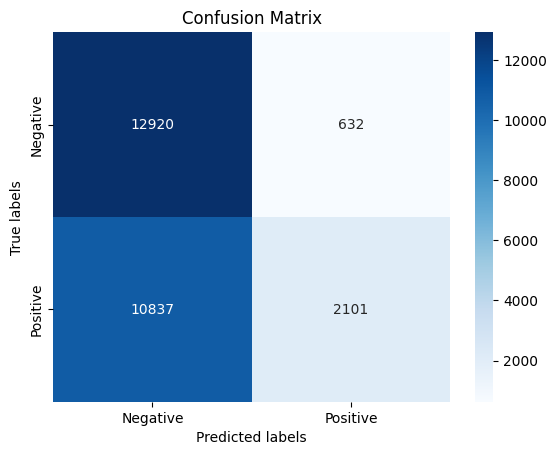

In [9]:
# 분류 성능 확인
predictions = np.array(pred1)
target_np = np.array(y_test)

# Data imbalance check
print(f"0(negative) target ratio: {np.sum(target_np == 0) / len(target_np)}")
print(f"1(positive) target ratio: {np.sum(target_np == 1) / len(target_np)}")
print('-----------------------------------')

# metrics
accuracy = accuracy_score(target_np, predictions) # 정확도 계산
precision = precision_score(target_np, predictions) # 정밀도 계산
recall = recall_score(target_np, predictions) # 재현율 계산
f1 = f1_score(target_np, predictions) # F1 스코어 계산

print(f'Accuracy: {accuracy.round(4)}')
print(f'Precision: {precision.round(4)}')
print(f'Recall: {recall.round(4)}')
print(f'F1 Score: {f1.round(4)}')
print('-----------------------------------')

# confusion matrix
cm = confusion_matrix(target_np, predictions) # 혼동 행렬 계산
fig, ax = plt.subplots() # 혼동 행렬 시각화
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)  # 혼동 행렬을 히트맵으로 표시
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Negative', 'Positive'])
ax.yaxis.set_ticklabels(['Negative', 'Positive'])
plt.show()


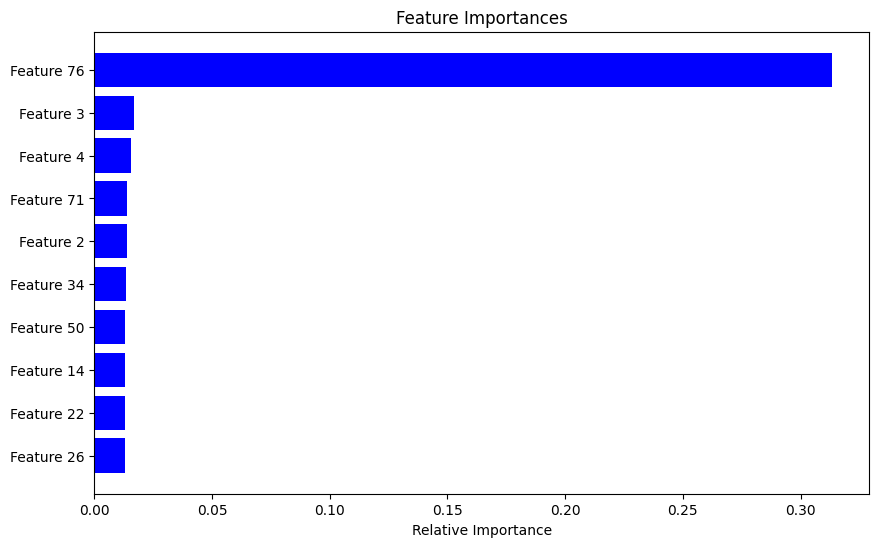

In [10]:
# feature importance 추출 및 시각화
feature_importances = model.feature_importances_
indices = np.argsort(feature_importances)[::-1]
top_n_indices = indices[:10]

# 상위 10개의 특성 이름 및 중요도
top_features = [f'Feature {i}' for i in top_n_indices]
top_importances = feature_importances[top_n_indices]

# 시각화
plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.barh(range(len(top_n_indices)), top_importances[::-1], color='b', align='center')
plt.yticks(range(len(top_n_indices)), np.array(top_features)[::-1])
plt.xlabel('Relative Importance')
plt.show()

In [19]:
# top 10 cols by feature importance
top_10_cols = df.drop(columns=['window_start', 'window_end', 'num_rows', 'time_id']).columns[[76, 3, 4, 71, 2, 34, 50, 14, 22, 26]]

for col in top_10_cols:
    print(col)

highest_possible_return
trade_vol
volume_power
ob_end_bias_4
high_low_gap
ob_end_as_6
ob_end_as_10
ob_end_as_1
ob_end_as_3
ob_end_as_4
